In [1]:
import collections
import math
import enum

import dill
import pytest
import numpy as np
import pandas as pd
import scipy.ndimage
import matplotlib
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
import cv2 as cv
import carla

from collect.generate.map import MapDataExtractor
import collect.visualize.trajectron
import utility.npu
import utility as util
import carlautil

CARLA_HOST = '127.0.0.1'
CARLA_PORT = 2000

In [3]:
def get_world_with(client, map_name):
    world = client.get_world()
    carla_map = world.get_map()
    if carla_map.name != map_name:
        world = client.load_world(map_name)
        carla_map = world.get_map()
    return world, carla_map

def get_client_and_world_with(map_name):
    client = carla.Client(CARLA_HOST, CARLA_PORT)
    client.set_timeout(10.0)
    world, carla_map = get_world_with(client, map_name)
    return client, world, carla_map

roadpath = '../cache/map_data.Town03.pkl'
with open(roadpath, 'rb') as f:
    map_data = dill.load(f, encoding='latin1')
    map_data = util.AttrDict(map_data)

In [16]:
class RoadBoundaryConstraint(object):
    """Create bounding boxes for road boundary."""
    
    __DIFF = 0.5
    __STEPSIZE = 1.0
    __VIOLTOL = 0.03
    __PRECISION = 1.0
    __DELTA = 0.25
    __K = 3
    __EPS = 1e-3

    @staticmethod
    def __pad_junction_mask(mask):
        diff_mask = np.diff(mask)
        diff_mask = np.r_[[False], diff_mask] | np.r_[diff_mask, [False]]
        mask &= ~diff_mask
        return mask

    @staticmethod
    def __split_line_by_mask(X, mask):
        """Split lines of items into boundary
        overlapping segments according to mask."""
        indices = np.where(np.diff(mask, prepend=np.nan))[0][1:]
        splits = []
        for i in range(len(indices)):
            if i == 0:
                splits.append(X[:indices[i]+1])
            else:
                splits.append(X[indices[i-1]:indices[i]+1])
        splits.append(X[indices[-1]:])
        split_mask = (np.arange(len(splits)) % 2 == 0) ^ ~mask[0]
        return splits, split_mask
    
    @staticmethod
    def __interval_index_ids(wps, distances):
        data = util.map_to_ndarray(
            lambda wp: [wp.is_junction, wp.road_id, wp.section_id, wp.lane_id], wps
        )[1:]
        return pd.DataFrame(
            data,
            columns=["is_junction", "road_id", "section_id", "lane_id"],
            index=pd.IntervalIndex.from_breaks(distances)
        )

    def compute_curvature(self, ddspline, d):
        """Find the curvature given distance from start of spline."""
        return np.linalg.norm(ddspline(d))
    
    def compute_segment_length(self, k):
        """Compute the segment length for a curvature."""
        return 2*np.arccos(1/(k*self.__DELTA + 1))/k

    def compute_violation(self, s, k):
        """Compute the amount of violation in range [0, 1]
        from given segment of length s covering a road with curvature k"""
        if s*k < math.pi:
            return max(0., 1 - (1 + self.__DELTA*k)*np.cos(0.5*k*s))
        else:
            return 1.

    def __compute_cover_vertices_disc(self, spline, dspline, ddspline, dist1, dist2):
        """Compute vertices of 4 sided cover for spline.
        NOTE: doesn't use derivative to create cover"""
        X1    = spline(dist1)
        X2    = spline(dist2)
        X1p   = spline(dist1 + self.__DIFF)
        unit1 = util.npu.unit_normal_2d(X1, X1p)
        X2p   = spline(dist2 - self.__DIFF)
        unit2 = util.npu.unit_normal_2d(X2p, X2)
        p1 = X1 + self.delta*unit1
        p2 = X2 + self.delta*unit2
        p3 = X2 - self.delta*unit2
        p4 = X1 - self.delta*unit1
        return np.stack((p1, p2, p3, p4))

    def __compute_cover_vertices(self, spline, dspline, ddspline, dist1, dist2):
        """Compute vertices of 4 sided cover for spline.
        Slight/serious(?) loss of performance to when covering CARLA waypoints."""
        X1   = spline(dist1)
        dX1  = dspline(dist1)
        ddX1 = ddspline(dist1)
        X2   = spline(dist2)
        dX2  = dspline(dist2)
        ddX2 = ddspline(dist2)
        sgn1 = np.sign(dX1[0]*ddX1[1] - dX1[1]*ddX1[0])
        sgn2 = np.sign(dX2[0]*ddX2[1] - dX2[1]*ddX2[0])
        p1 = X1 + self.delta*sgn1* ddX1 / np.linalg.norm(ddX1)
        p2 = X2 + self.delta*sgn2* ddX2 / np.linalg.norm(ddX2)
        p3 = X2 - self.delta*sgn2* ddX2 / np.linalg.norm(ddX2)
        p4 = X1 - self.delta*sgn1* ddX1 / np.linalg.norm(ddX1)
        return np.stack((p1, p2, p3, p4))
    
    def cover_along_waypoints_varyingsize(self):
        polytopes = []
        vertex_set = []
        mask = []
        segment_lengths = []
        postprocess_distances = [0.]
        ids = []
        for in_junction, distances, spline, dspline, ddspline in zip(
            self.split_mask, self.distances_splits, self.splines, self.dsplines, self.ddsplines
        ):
            acc_distance = distances[0]
            max_distance = distances[-1]
            # print(acc_distance, max_distance)
            while acc_distance < max_distance:
                k = self.compute_curvature(ddspline, acc_distance)
                segment_length = self.compute_segment_length(k)
                segment_length = min(segment_length, max_distance - acc_distance)
                query_distances = np.arange(acc_distance, acc_distance + segment_length, self.__STEPSIZE)
                query_distance = None
                if query_distances.size == 1:
                    """place bounding box between acc_distance and (acc_distance + segment_length)"""
                    next_distance = acc_distance + segment_length
                else:
                    """since curvature of spline may change, figure out the maximum distance ahead
                    from initial distance where the curvature does not change drastically."""
                    prev_query_distance = None
                    for query_distance in query_distances:
                        k1 = self.compute_curvature(ddspline, query_distance)
                        k2 = self.compute_curvature(ddspline, query_distance + self.__STEPSIZE)
                        has_viol1 = self.compute_violation(segment_length, k1) > self.__VIOLTOL
                        has_viol2 = self.compute_violation(segment_length, k2) > self.__VIOLTOL
                        if has_viol1 and has_viol2:
                            break
                    if query_distance == query_distances[-1]:
                        next_distance = acc_distance + segment_length
                    else:
                        next_distance = query_distance
                        segment_length = next_distance - acc_distance
                if acc_distance == next_distance:
                    raise Exception("no progression")
                vertices = self.__compute_cover_vertices_disc(
                    spline, dspline, ddspline, acc_distance, next_distance
                )
                A, b = util.npu.vertices_to_halfspace_representation(vertices)
                polytopes.append((A, b))
                vertex_set.append(vertices)
                mask.append(in_junction)
                segment_lengths.append(segment_length)
                postprocess_distances.append(next_distance)
                ids.append(self.ids_df.loc[next_distance - acc_distance].values)
                acc_distance = next_distance
        ids = pd.DataFrame(
            ids,
            columns=["is_junction", "road_id", "section_id", "lane_id"],
            index=pd.IntervalIndex.from_breaks(postprocess_distances)
        )
        ids["polytope_id"] = range(len(polytopes))
        return util.AttrDict(
            polytopes=polytopes,
            segment_lengths=segment_lengths,
            mask=mask,
            distances=postprocess_distances,
            positions=np.mean(np.stack(vertex_set), axis=1),
            ids=ids
        )
    
    def __init__(self, start_wp, max_distance, delta, choices=[]):
        """Constructor.
    
        Parameters
        ==========
        start_wp : carla.Waypoint
            Waypoint designating the start of the path.
        max_distance : float
            Maximum distance of path from start_wp we want to sample from.
        delta : float
            Size of road.
        choices : list of int
            Indices of turns at each junction along the path from start_wp onwards.
            If there are more junctions than indices contained in choices, then 
            choose default turn.
        """
        self.delta = delta
        (
            self.waypoints, self.points, self.distances
        ) = carlautil.collect_points_along_path(
            start_wp, choices, max_distance, precision=self.__PRECISION, flip_y=True
        )
        self.distance_to_point = pd.DataFrame(
            {
                "x": self.points[1:, 0],
                "y": self.points[1:, 1],
                "distances": self.distances[1:]},
            index=pd.IntervalIndex.from_breaks(self.distances)
        )
        self.junction_mask = self.__pad_junction_mask(
            util.map_to_ndarray(lambda wp: wp.is_junction, self.waypoints)
        )
        self.ids_df = self.__interval_index_ids(self.waypoints, self.distances)
        self.points_splits, self.split_mask = self.__split_line_by_mask(self.points, self.junction_mask)
        self.distances_splits, _ = self.__split_line_by_mask(self.distances, self.junction_mask)
        self.splines = []
        self.dsplines = []
        self.ddsplines = []
        for distances, points in zip(self.distances_splits, self.points_splits):
            spline = scipy.interpolate.CubicSpline(distances, points, axis=0)
            """Can make spline with another degree"""
            #self.spline = scipy.interpolate.make_interp_spline(
            #    self.distances, self.points, k=self.__K, axis=0
            #)
            """Can be LSQ B-spline, if waypoint points aren't aligned, but not necessary"""
            #t = np.linspace(self.distances[1], self.distances[-2], n_points // 2)
            #t = np.r_[(self.distances[0],)*(self.__K+1), t, (self.distances[-1],)*(self.__K+1)]
            #self.spline = scipy.interpolate.make_lsq_spline(
            #    self.distances, self.points, t=t, k=self.__K, axis=0
            #)
            dspline = spline.derivative(1)
            ddspline = spline.derivative(2)
            self.splines.append(spline)
            self.dsplines.append(dspline)
            self.ddsplines.append(ddspline)
        self.road_segs = self.cover_along_waypoints_varyingsize()
        
    @property
    def path_length(self):
        return self.distances[-1]
    
    def get_point_from_start(self, distance):
        """Get goal point distance away from starting waypoint."""
        for spline in self.splines:
            if spline.x[0] <= distance and distance <= spline.x[-1]:
                return spline(distance)
        return self.points[-1]

        
    def collect_segs_polytopes_and_goal(self, position, distance):
        """Collect the road boundary constraints and goal sufficient
        for the agent to go from a given position to a given distance
        further down the path.
        """
        beg_idx = np.argmin(np.linalg.norm(self.points - position, axis=1))
        beg_dist = self.distances[beg_idx]
        end_dist = min(self.distances[beg_idx] + distance, self.path_length)
        goal = self.distance_to_point.loc[end_dist][["x", "y"]].values
        beg_poly_id = max(self.road_segs.ids.loc[beg_dist].polytope_id - 1, 0)
        end_poly_id = min(
            self.road_segs.ids.loc[end_dist].polytope_id + 1,
            len(self.road_segs.polytopes) - 1
        )
        return util.AttrDict(
            polytopes=self.road_segs.polytopes[beg_poly_id:end_poly_id],
            ids=util.range_to_list(beg_poly_id, end_poly_id),
            mask=self.road_segs.mask[beg_poly_id:end_poly_id],
            goal=goal
        )


In [5]:
client, world, carla_map = get_client_and_world_with("Town03")
spawn_points = carla_map.get_spawn_points()

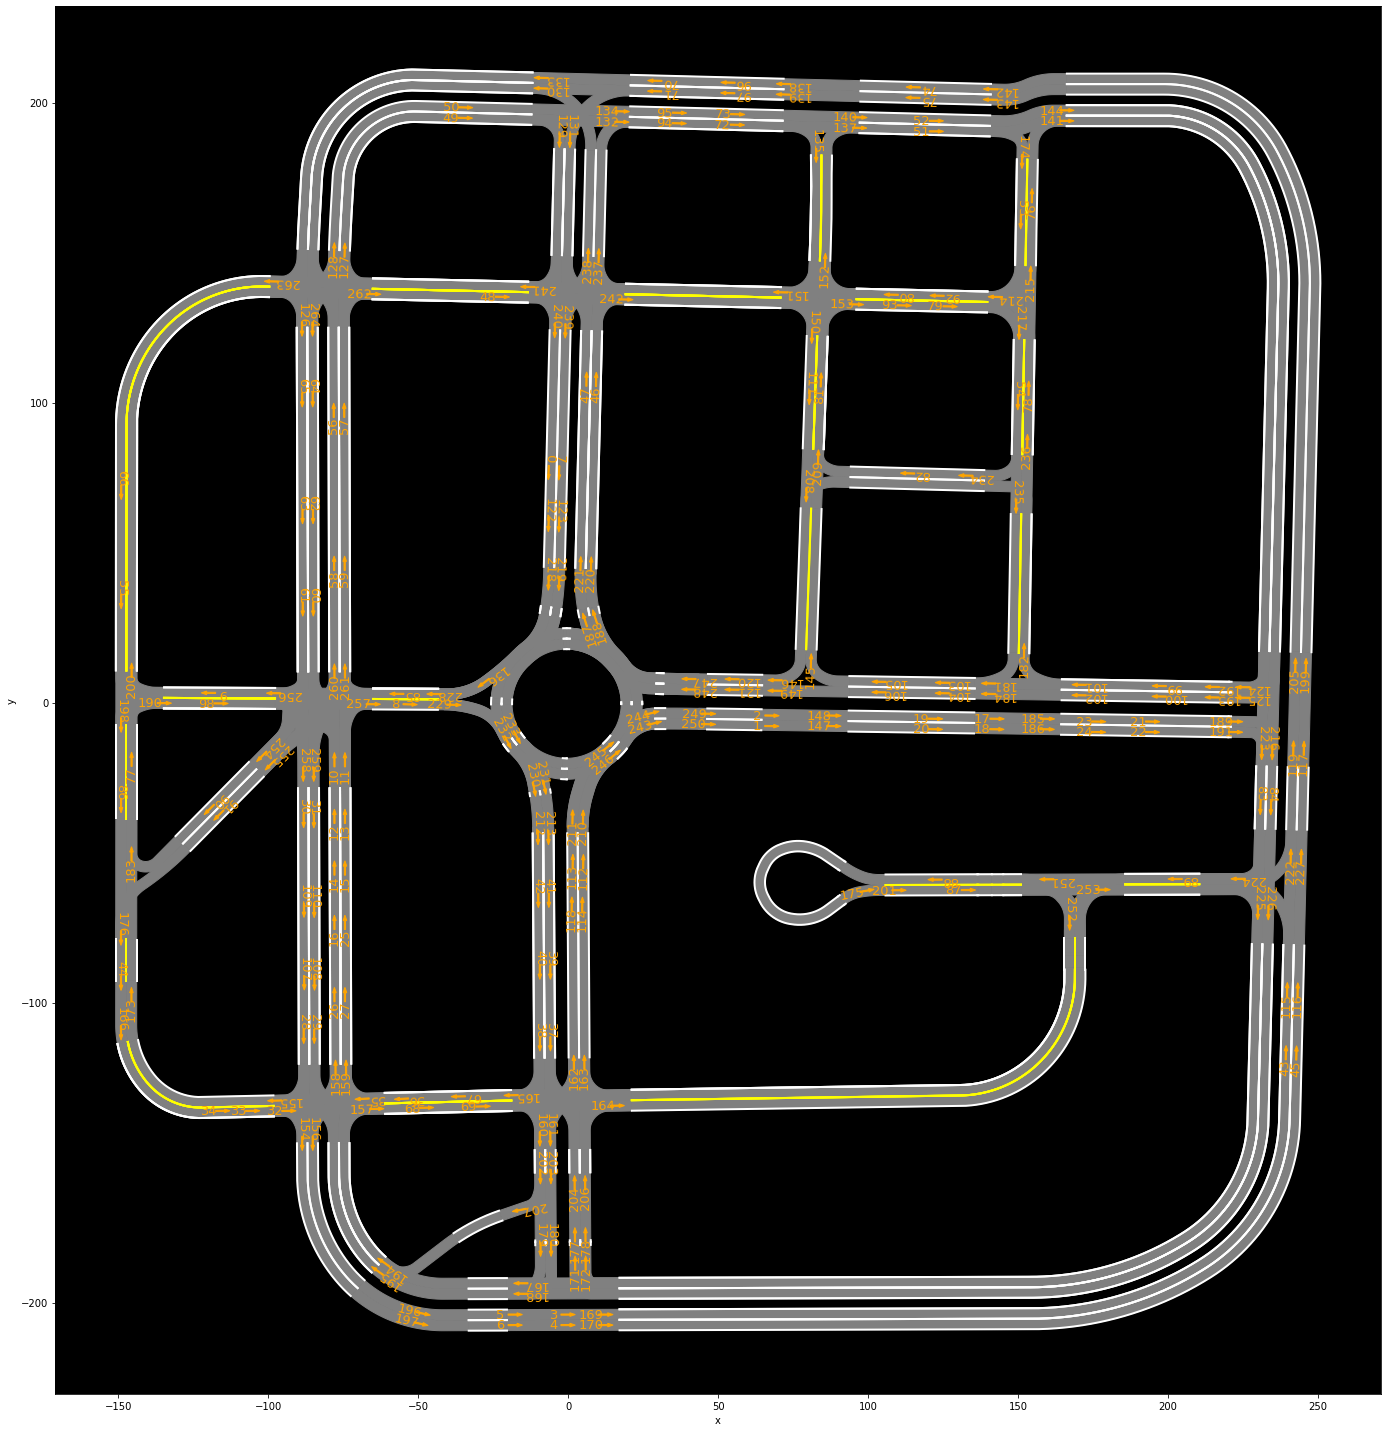

In [6]:
# Plot map overlay and label spawning points.
fig, ax = plt.subplots(figsize=(20,20))
collect.visualize.trajectron.render_entire_map(ax, map_data)

for idx, sp in enumerate(spawn_points):
    spp = carla.Transform(
            sp.location - 2.5 * sp.get_forward_vector(),
            sp.rotation)
    x, y, _ = carlautil.to_location_ndarray(spp)
    _, yaw, _ = carlautil.to_rotation_ndarray(sp)
    yaw = util.reflect_radians_about_x_axis(yaw)
    ax.text(
        x, -y, str(idx), color='orange', size=13, rotation=np.rad2deg(yaw),
        ha="center", va="center",
    )
    x, y, _ = carlautil.to_location_ndarray(sp)
    ax.arrow(x, -y, 3*np.cos(yaw), 3*np.sin(yaw), width=0.4, color='orange')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_aspect('equal')
ax.set_facecolor('black')
fig.tight_layout()

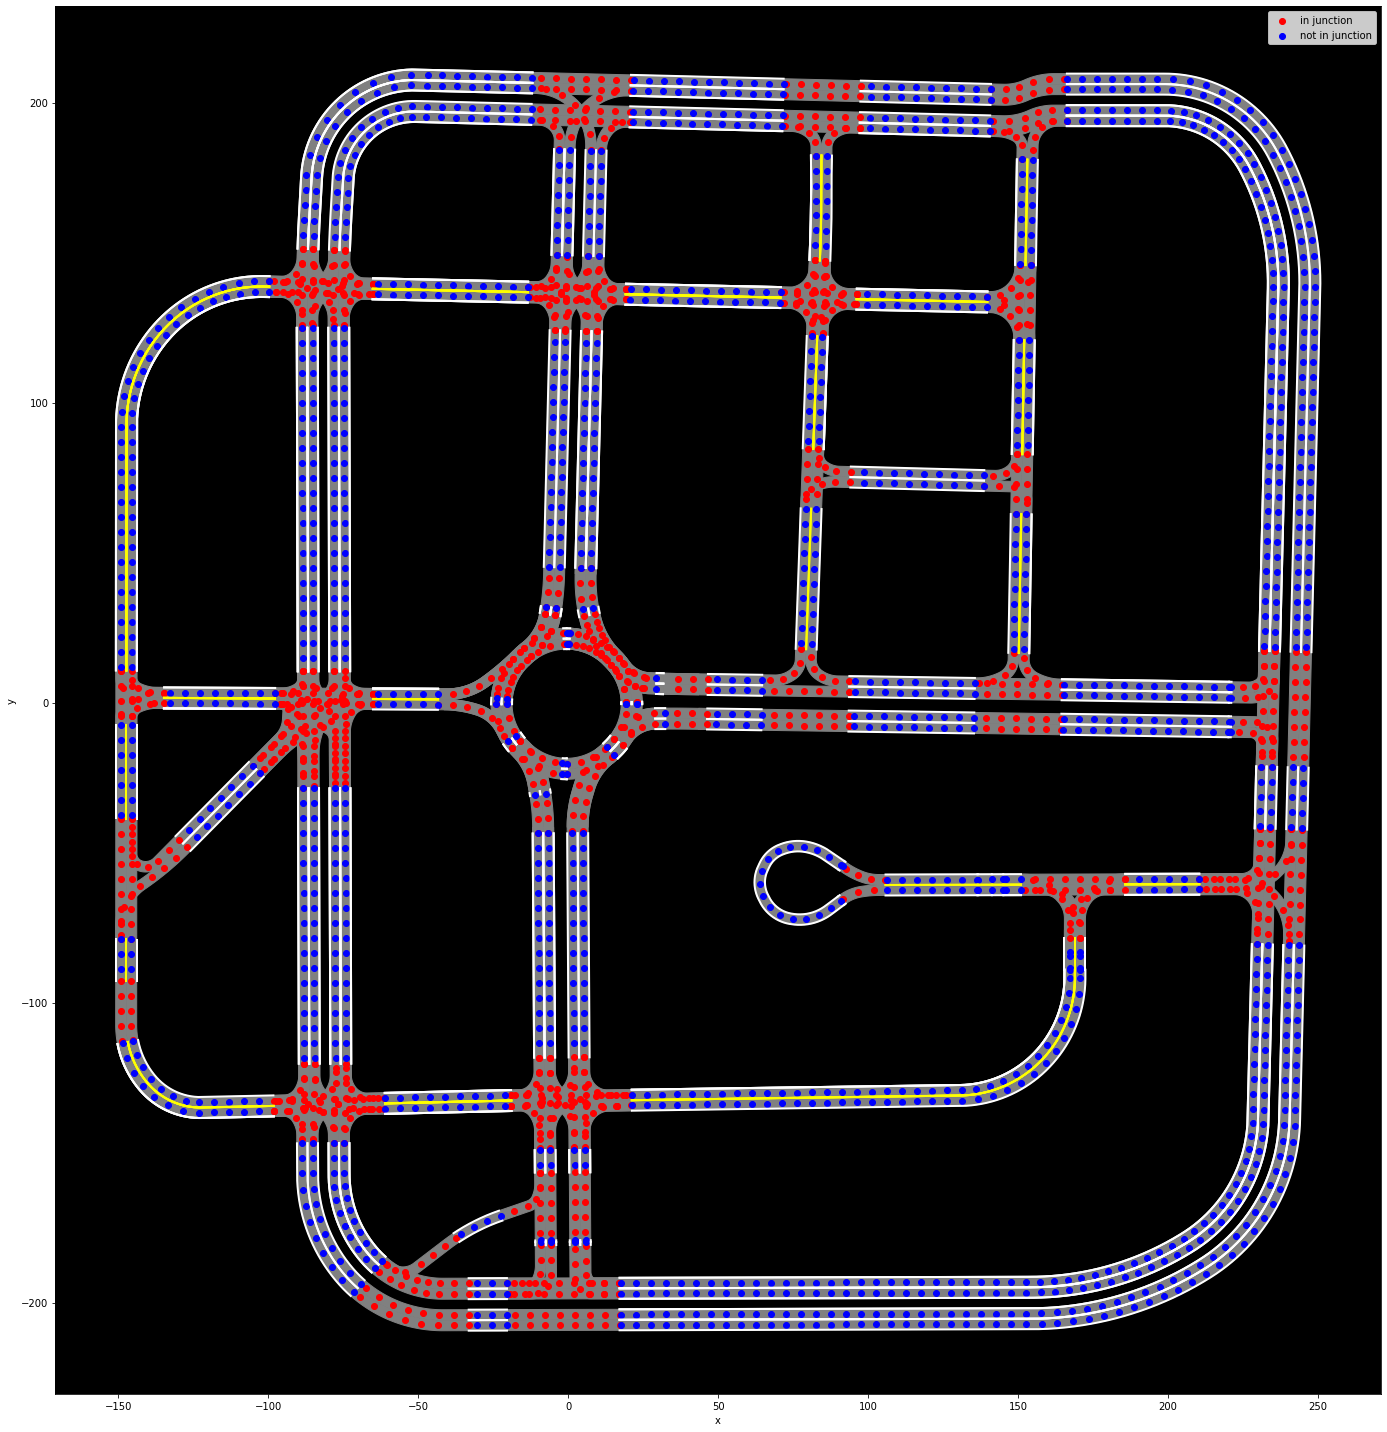

In [7]:
# Plot map overlay and label points on the road inside/outside road junctions.
fig, ax = plt.subplots(figsize=(20,20))
collect.visualize.trajectron.render_entire_map(ax, map_data)

wps = carla_map.generate_waypoints(5)
points = util.map_to_ndarray(to_point, wps)
junction_mask = util.map_to_ndarray(lambda wp: wp.is_junction, wps)
ax.scatter(*points[junction_mask].T, c="r", label="in junction")
ax.scatter(*points[~junction_mask].T, c="b", label="not in junction")
ax.legend()

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_aspect('equal')
ax.set_facecolor('black')
fig.tight_layout()

In [7]:
def plot_rbc(ax, rbc):
    ax.scatter(*rbc.points[rbc.junction_mask].T, c="r", s=2, label="in junction")
    ax.scatter(*rbc.points[~rbc.junction_mask].T, c="b", s=2, label="not in junction")
    ax.set_aspect("equal")
    payload = rbc.road_segs
    for (A, b), in_junction in zip(payload.polytopes, payload.mask):
        if in_junction:
            util.npu.plot_h_polyhedron(ax, A, b, fc='r', ec='r', alpha=0.3)
        else:
            util.npu.plot_h_polyhedron(ax, A, b, fc='b', ec='b', alpha=0.3)
        
        """Capture QhullError if needed"""
#         try:
#             if in_junction:
#                 util.npu.plot_h_polyhedron(ax, A, b, fc='r', ec='r', alpha=0.3)
#             else:
#                 util.npu.plot_h_polyhedron(ax, A, b, fc='b', ec='b', alpha=0.3)
#         except scipy.spatial.qhull.QhullError:
#             # possible to get `qhull input error: feasible point is not clearly inside halfspace`
#             print("hit q-hull error exception")
    return payload

In [64]:
"""Find ID information on of a waypoint:

id (hash of road, section, lane, s)
- road_id (OpenDRIVE road's id)
- section_id (OpenDRIVE section's id, based on the order that
              they are originally defined)
- lane_id (OpenDRIVE lane's id, this value can be positive
           or negative which represents the direction of the
           current lane with respect to the road)
- s (OpenDRIVE s value of the current position)
"""

starting_point = 121
sp = spawn_points[starting_point]
wp = carla_map.get_waypoint(sp.location)
wp.road_id, wp.section_id, wp.lane_id, wp.s

(8, 0, -1, 7.666656017303486)

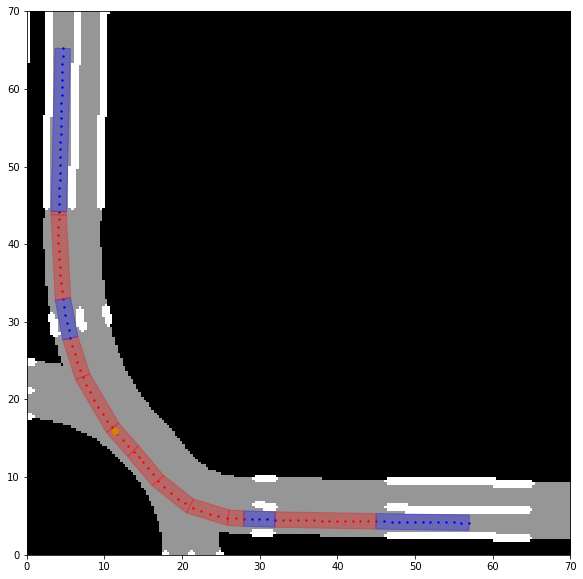

In [22]:
starting_point = 121
sp = spawn_points[starting_point]
start_wp = carla_map.get_waypoint(sp.location)
max_distance = 100

delta = 2.0
choices = []
rbc = RoadBoundaryConstraint(start_wp, max_distance, delta, choices=choices)

fig, ax = plt.subplots(figsize=(10, 10))
extent = (0, 70, 0, 70,)
collect.visualize.trajectron.render_map_crop(ax, map_data, extent)
plot_rbc(ax, rbc)

# get goal point from start
point = rbc.get_point_from_start(50)
ax.scatter(*point, c="y")

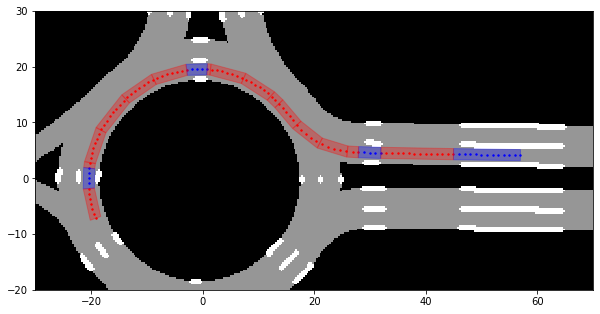

In [68]:
starting_point = 121
sp = spawn_points[starting_point]
start_wp = carla_map.get_waypoint(sp.location)
max_distance = 100
delta = 2.0
choices = [1, 1, 1, 1]
rbc = RoadBoundaryConstraint(start_wp, max_distance, delta, choices=choices)

fig, ax = plt.subplots(figsize=(10, 10))
extent = (-30, 70, -20, 30,)
collect.visualize.trajectron.render_map_crop(ax, map_data, extent)
plot_rbc(ax, rbc)
None

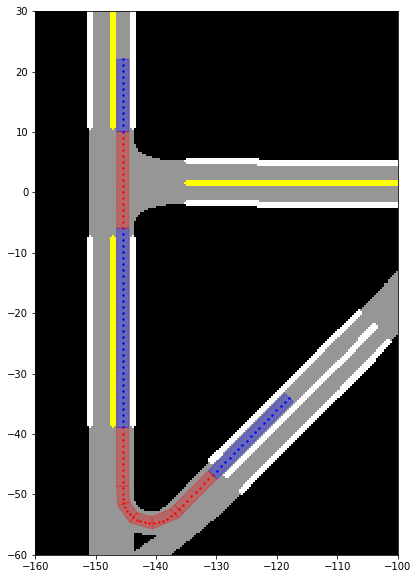

In [23]:
starting_point = 90
sp = spawn_points[starting_point]
start_wp = carla_map.get_waypoint(sp.location)
max_distance = 110
delta = 2.0
choices = [1, 1, 1, 1]
rbc = RoadBoundaryConstraint(start_wp, max_distance, delta, choices=choices)

fig, ax = plt.subplots(figsize=(10, 10))
extent = (-160, -100, -60, 30,)
collect.visualize.trajectron.render_map_crop(ax, map_data, extent)
plot_rbc(ax, rbc)
None

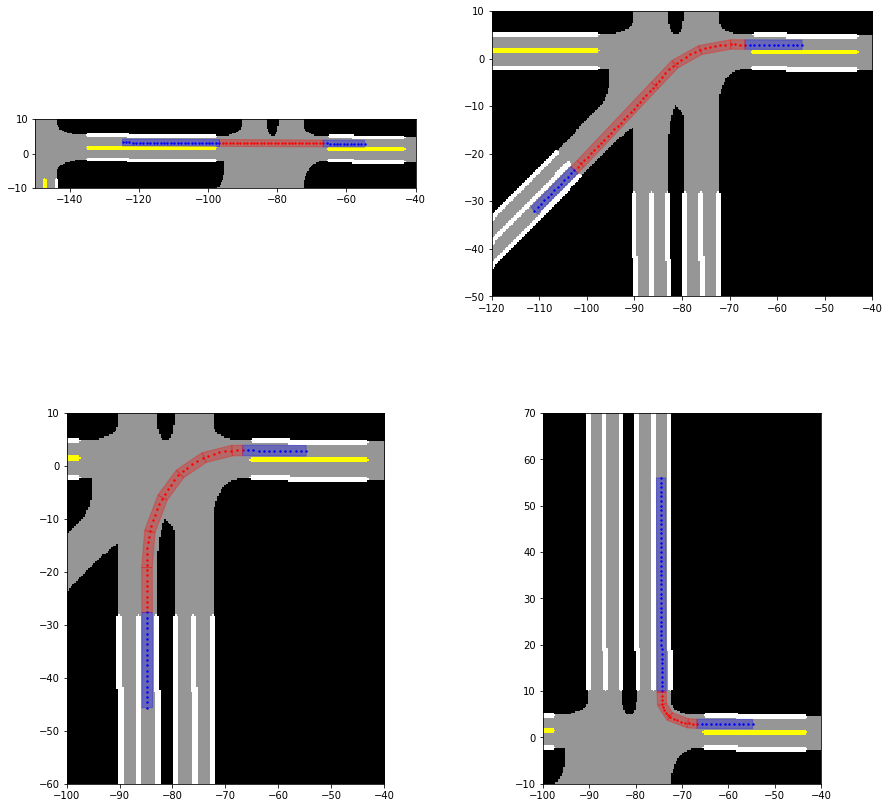

In [24]:
starting_point = 85
sp = spawn_points[starting_point]
start_wp = carla_map.get_waypoint(sp.location)
max_distance = 70
delta = 2.0
choices_set = util.map_to_list(lambda i : (i,), range(4))
extent_set = [
    (-150, -40, -10, 10),
    (-120, -40, -50, 10),
    (-100, -40, -60, 10),
    (-100, -40, -10, 70),
]

fig, axes = plt.subplots(2, 2, figsize=(15, 15))
axes = axes.ravel()
for ax, choices, extent in zip(axes, choices_set, extent_set):
    rbc = RoadBoundaryConstraint(start_wp, max_distance, delta, choices=choices)
    collect.visualize.trajectron.render_map_crop(ax, map_data, extent)
    plot_rbc(ax, rbc)
None

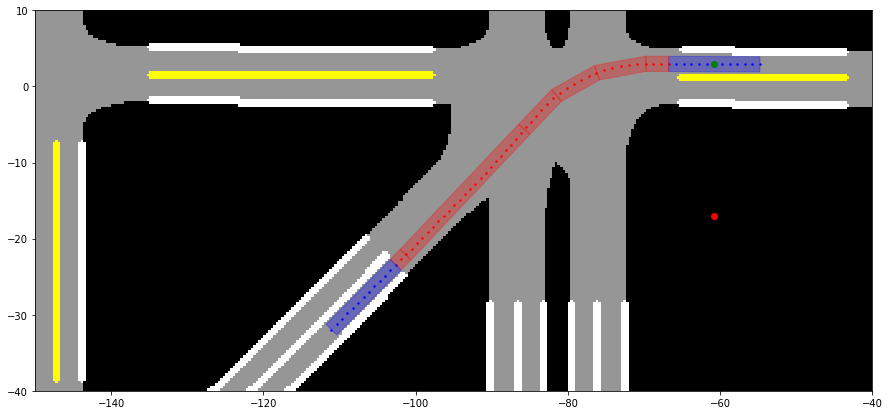

In [26]:
starting_point = 85
sp = spawn_points[starting_point]
start_wp = carla_map.get_waypoint(sp.location)
max_distance = 70
delta = 2.0
choices = (1,)
extent = (-150, -40, -40, 10,)
rbc = RoadBoundaryConstraint(start_wp, max_distance, delta, choices=choices)

fig, ax = plt.subplots(figsize=(15, 15))
collect.visualize.trajectron.render_map_crop(ax, map_data, extent)
payload = plot_rbc(ax, rbc)

A, b = payload.polytopes[0]
x = payload.positions[0]
c = "g" if np.all(A @ x <= b) else "r"
ax.scatter(*x, c=c)
x = x + np.array([0, -20])
c = "g" if np.all(A @ x <= b) else "r"
ax.scatter(*x, c=c)
None

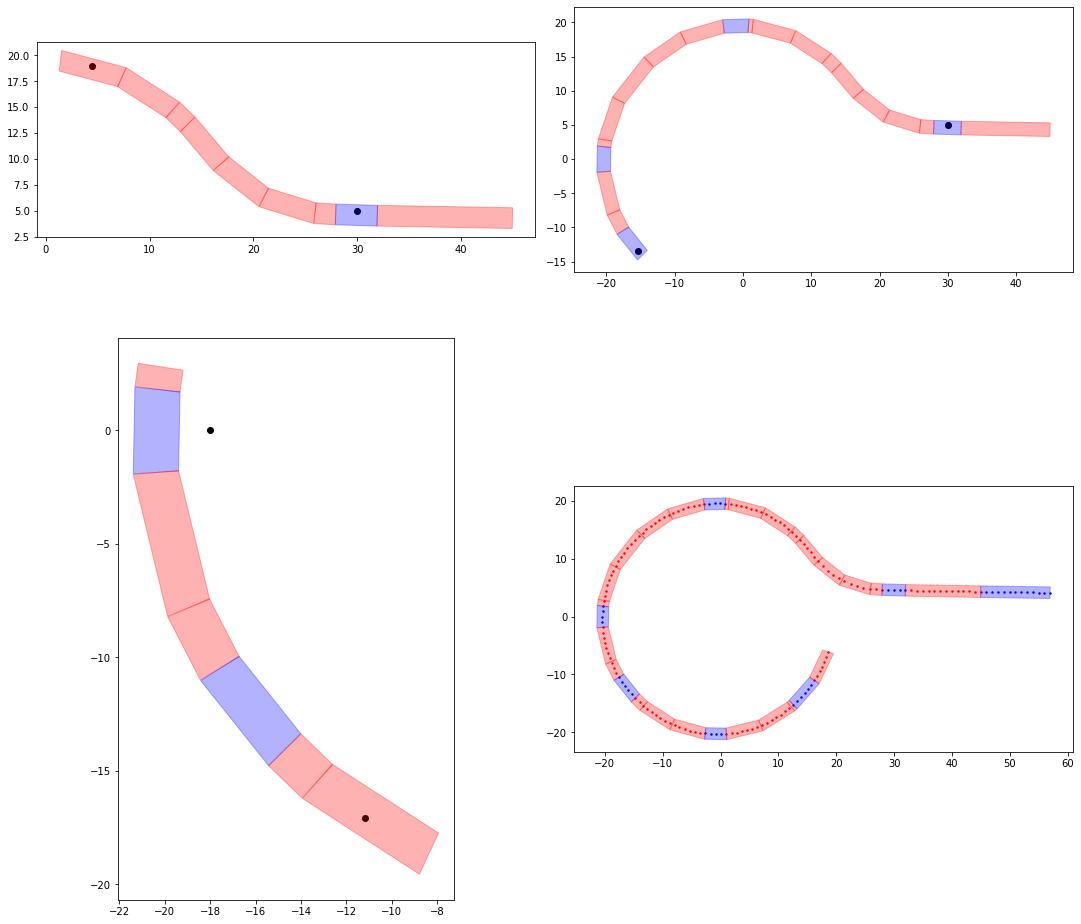

In [8]:
starting_point = 121
sp = spawn_points[starting_point]
start_wp = carla_map.get_waypoint(sp.location)
max_distance = 150
delta = 2.0
choices = (1, 1, 1, 1,)
rbc = RoadBoundaryConstraint(start_wp, max_distance, delta, choices=choices)

fig, axes = plt.subplots(2, 2, figsize=(15, 15))
axes = axes.ravel()
# extent = (-150, -40, -40, 10,)
# collect.visualize.trajectron.render_map_crop(ax, map_data, extent)
payload = plot_rbc(axes[-1], rbc)

for idx, (pos, dist) in enumerate(zip(
    [[30, 5], [30, 5], [-18, 0]],
    [30, 80, 20]
)):
    pos_payload = rbc.collect_segs_polytopes_and_goal(pos, dist)
    both = np.stack((pos, pos_payload.goal))
    axes[idx].scatter(*both.T, c="k")

    for (A, b), _, in_junction in zip(
        pos_payload.polytopes, pos_payload.ids, pos_payload.mask
    ):
        if in_junction:
            util.npu.plot_h_polyhedron(axes[idx], A, b, fc='r', ec='r', alpha=0.3)
        else:
            util.npu.plot_h_polyhedron(axes[idx], A, b, fc='b', ec='b', alpha=0.3)
    axes[idx].set_aspect("equal")
fig.tight_layout()